In [1]:
# import the necessary libraries for the project!
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Practice: Forecast the daily closing price of S&P 500

In [2]:
# let's import the data
df = pd.read_excel(r'C:\Users\HP\pyfold\data_ts\S&P500.xlsx')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-05-05,4270.430176,4270.430176,4106.009766,4146.870117,4146.870117,5077030000
1,2022-05-06,4128.169922,4157.689941,4067.909912,4123.339844,4123.339844,5116940000
2,2022-05-09,4081.270020,4081.270020,3975.479980,3991.239990,3991.239990,5954520000
3,2022-05-10,4035.179932,4068.820068,3958.169922,4001.050049,4001.050049,5885820000
4,2022-05-11,3990.080078,4049.090088,3928.820068,3935.179932,3935.179932,5816140000


In [3]:
df.shape

(251, 7)

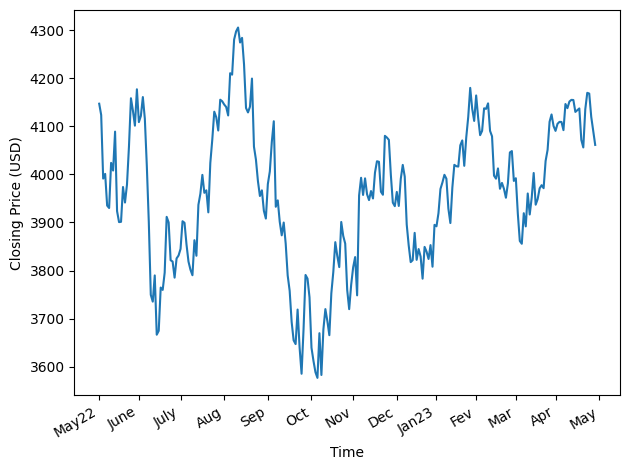

In [4]:
# let's plot the series for a quick visualization

fig, ax = plt.subplots()

ax.plot(df['Close'])

ax.set_xlabel('Time')
ax.set_ylabel('Closing Price (USD)')

plt.xticks([0, 20, 41, 63, 85, 107, 128, 150, 170, 190, 210, 230, 252],
           ['May22', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan23', 'Fev', 'Mar', 'Apr', 'May'])

fig.autofmt_xdate()
plt.tight_layout()

In [5]:
# let's check the stationarity with the Augmented Dickey Fuller test

ADF_test_stat = adfuller(df['Close'])

print('the ADF statistic is:', ADF_test_stat[0])
print('---------------------------------')
print('the p-value is:', ADF_test_stat[1])

the ADF statistic is: -2.943353363186357
---------------------------------
the p-value is: 0.0405338863058714


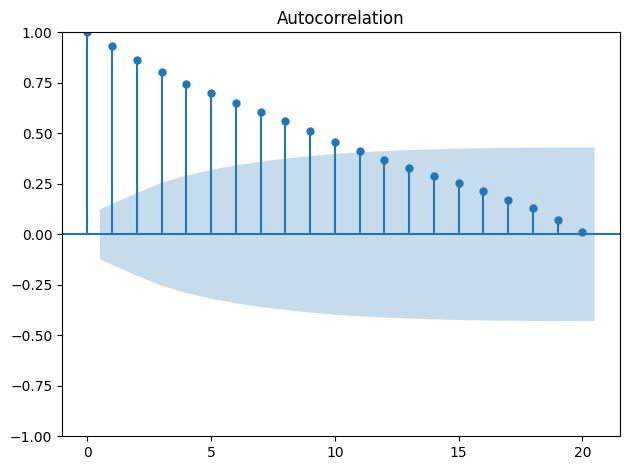

In [6]:
# let's plot the ACF

plot_acf(df['Close'], lags=20)
plt.tight_layout()

the lags are highly correlated even if the series seems stationary, let's perform a one order differencing

In [7]:
# let's do a differencing and check again the ADF test

diff_df = np.diff(df['Close'])

ADF_test_stat1 = adfuller(diff_df)

print('the ADF statistic is:', ADF_test_stat1[0])
print('---------------------------------')
print('the p-value is:', ADF_test_stat1[1])

the ADF statistic is: -15.515471479602965
---------------------------------
the p-value is: 2.3193533511021015e-28


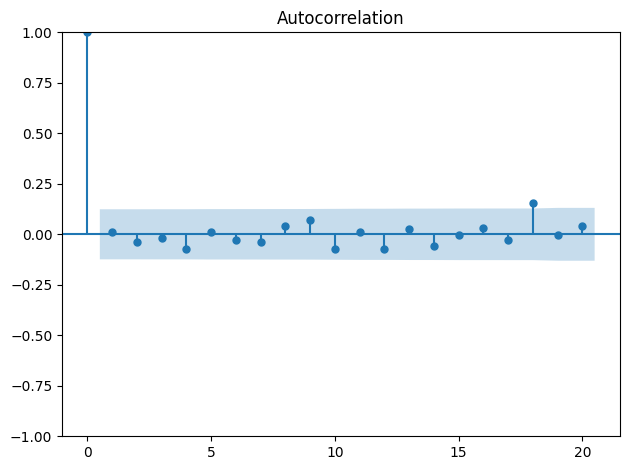

In [8]:
# let's plot the ACF again

plot_acf(diff_df, lags=20)
plt.tight_layout()

After a one order differencing, the series has a very low ADF statistic and a p-value < 0.05, meaning we can reject the null hypothesis stating there is a unit root; therefore the series is stationary. Moreover, the Autorecorrelation plot shows no significant coefficient except in lag 18, thus, the series is uncorrelated. __We can conclude it can be approximated as random walk!__

## Forecast using naive methods

In [9]:
# let's split the data into train and test set

train  = df[:244]
test = df[244:]

print(len(train), len(test))

244 7


In [10]:
# let's forecast using the historical mean

mean = np.mean(train['Close'])

test.loc[:, 'pred_mean'] = mean
test

,Date,Open,High,Low,Close,Adj Close,Volume,pred_mean
244,2023-04-26,4087.780029,4089.669922,4049.350098,4055.989990,4055.989990,3837030000,3956.812594
245,2023-04-27,4075.290039,4138.240234,4075.290039,4135.350098,4135.350098,3750550000,3956.812594
246,2023-04-28,4129.629883,4170.060059,4127.180176,4169.479980,4169.479980,4087800000,3956.812594
247,2023-05-01,4166.790039,4186.919922,4164.120117,4167.870117,4167.870117,3321370000,3956.812594
248,2023-05-02,4164.100098,4164.100098,4089.719971,4119.580078,4119.580078,4486130000,3956.812594
249,2023-05-03,4122.250000,4148.299805,4088.860107,4090.750000,4090.750000,4246510000,3956.812594
250,2023-05-04,4082.550049,4082.610107,4048.280029,4061.219971,4061.219971,4920090000,3956.812594


In [11]:
# let's forecast using the last known value

Last_value = train['Close'].iloc[-1]

test.loc[:, 'pred_last'] = Last_value

test

,Date,Open,High,Low,Close,Adj Close,Volume,pred_mean,pred_last
244,2023-04-26,4087.780029,4089.669922,4049.350098,4055.989990,4055.989990,3837030000,3956.812594,4071.629883
245,2023-04-27,4075.290039,4138.240234,4075.290039,4135.350098,4135.350098,3750550000,3956.812594,4071.629883
246,2023-04-28,4129.629883,4170.060059,4127.180176,4169.479980,4169.479980,4087800000,3956.812594,4071.629883
247,2023-05-01,4166.790039,4186.919922,4164.120117,4167.870117,4167.870117,3321370000,3956.812594,4071.629883
248,2023-05-02,4164.100098,4164.100098,4089.719971,4119.580078,4119.580078,4486130000,3956.812594,4071.629883
249,2023-05-03,4122.250000,4148.299805,4088.860107,4090.750000,4090.750000,4246510000,3956.812594,4071.629883
250,2023-05-04,4082.550049,4082.610107,4048.280029,4061.219971,4061.219971,4920090000,3956.812594,4071.629883


In [12]:
# let's forecast using a drift

deltaX = 244 - 1
deltaY = Last_value - df['Close'].iloc[0]

drift = deltaY/deltaX

print(drift)

-0.30963059259259396


In [13]:
xvals = np.arange(244, 251, 1)

drift_pred = drift*xvals + df['Close'].iloc[0]

test.loc[:, 'drift_pred'] = drift_pred

test

,Date,Open,High,Low,Close,Adj Close,Volume,pred_mean,pred_last,drift_pred
244,2023-04-26,4087.780029,4089.669922,4049.350098,4055.989990,4055.989990,3837030000,3956.812594,4071.629883,4071.320252
245,2023-04-27,4075.290039,4138.240234,4075.290039,4135.350098,4135.350098,3750550000,3956.812594,4071.629883,4071.010622
246,2023-04-28,4129.629883,4170.060059,4127.180176,4169.479980,4169.479980,4087800000,3956.812594,4071.629883,4070.700991
247,2023-05-01,4166.790039,4186.919922,4164.120117,4167.870117,4167.870117,3321370000,3956.812594,4071.629883,4070.391361
248,2023-05-02,4164.100098,4164.100098,4089.719971,4119.580078,4119.580078,4486130000,3956.812594,4071.629883,4070.081730
249,2023-05-03,4122.250000,4148.299805,4088.860107,4090.750000,4090.750000,4246510000,3956.812594,4071.629883,4069.772099
250,2023-05-04,4082.550049,4082.610107,4048.280029,4061.219971,4061.219971,4920090000,3956.812594,4071.629883,4069.462469


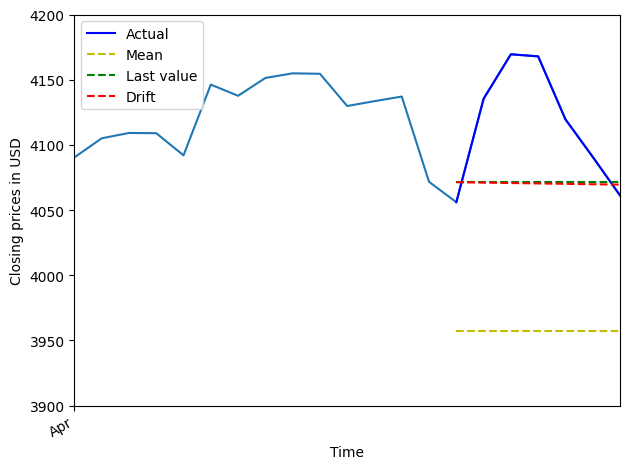

In [14]:
# let's plot the 3 predictions

fig, ax = plt.subplots()

ax.plot(df['Close'])
ax.plot(test['Close'], 'b-', label = 'Actual')
ax.plot(test['pred_mean'], 'y--', label = 'Mean')
ax.plot(test['pred_last'], 'g--', label = 'Last value')
ax.plot(test['drift_pred'], 'r--', label = 'Drift')

ax.legend(loc = 2)

ax.set_xlabel('Time')
ax.set_ylabel('Closing prices in USD')

plt.xticks([0, 20, 41, 63, 85, 107, 128, 150, 170, 190, 210, 230, 252],
           ['May22', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan23', 'Fev', 'Mar', 'Apr', 'May'])

ax.set_xlim(230, 250)
ax.set_ylim(3900, 4200)

fig.autofmt_xdate()
plt.tight_layout()

In [15]:
# let's calculate the Mean Squared Error

MSE_mean = mean_squared_error(test['Close'], test['pred_mean'])
MSE_lst = mean_squared_error(test['Close'], test['pred_last'])
MSE_drift = mean_squared_error(test['Close'], test['drift_pred'])

print(MSE_mean, MSE_lst, MSE_drift)

26688.26773187068 3702.1232169230466 3798.8684631939263


As we can see the predictions are very far from the actual data suggesting other sophisticated models